<a href="https://colab.research.google.com/github/L-ansari/Natural-Language-Processing-tasks/blob/master/LexiconCompare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import sklearn

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [79]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [80]:
""" Helper functions """


def encode_data(dataframe, column_name, encodedict):
  """column_name:  is a list of column head names
  encodedict:  is a dictionary encoding of labels"""
  
  dataframe.columns = column_name
  dataframe['label'] = dataframe['label'].map(encodedict) 

  return dataframe #  encode labels

def plot(dataframe,dataset ):
  #print("Reddit Dataset\n")
  print(f'Dataset: {dataset}',"\n")
  return sns.countplot(x = 'label', data=dataframe)

def split(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69, shuffle=True)
  return X_train, X_test, y_train, y_test 

def normalize (scaler, X_train, X_test):
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test

# note that y_pred has shape (N_samples,N_labels) while y_real has shape (N_samples,1)
# weights means weighting according to class frequencies
def loss_logloss(y_pred, y_real, weighted=False):
    weights = None
    if weighted:
        class_to_frequency = class_weights(y_real)
        weights = np.array([1/class_to_frequency[y-1] for y in y_real])
    loss = sklearn.metrics.log_loss(y_real, y_pred, sample_weight=weights, labels=[0,1])
    return loss
# array which tells for every class how many times it occurs in the training labels
# note that class labels start from 1 while class indices start from 0!
def class_weights(y):
    unique, counts = np.unique(y, return_counts=True)
    n_classes = 10
    class_weights = np.zeros(n_classes)
    for classNumber, count in zip(unique, counts):
            class_weights[classNumber-1] = count
    return class_weights


def get_feature(message):
  """This function gives out a dataframe of extracted features"""
  sn = SenticNet()

  polarity_value=0
  polarity_label=0
  introspection=0
  sensitivity=0
  temper=0
  attitude=0

  for word in (message):
    try:
      concept = sn.concept(word)
      pol_value = float(concept['polarity_value'])
      pol_label=concept['polarity_label']
      intros=float(concept['sentics']['introspection'])
      sensit=float(concept['sentics']['sensitivity'])
      temp=float(concept['sentics']['temper'])
      attit=float(concept['sentics']['attitude'])

      if  concept['polarity_label']=='positive':
        pol_label =1
      else:
        pol_label=0

      polarity_value += pol_value
      polarity_label +=pol_label
      introspection +=intros
      sensitivity +=sensit
      temper +=temp
      attitude +=attit

    except KeyError:
        pass
   
  return polarity_value , polarity_label, introspection, sensitivity, temper, attitude

def get_scentic_features(df): #dataframe

  df['polarity_value'] = 0
  df['polarity_label'] = 0
  df['sensitivity'] = 0
  df['introspection'] = 0
  df['temper'] = 0
  df['attitude'] = 0
  for i in range(df.shape[0]):
    polarity_value , polarity_label, introspection, sensitivity, temper, attitude=get_feature (word_tokenize(df['text'][i].lower()))
    df['polarity_value'][i] = polarity_value
    df['polarity_label'][i] = polarity_label
    df['sensitivity'][i] = sensitivity
    df['introspection'][i]= introspection
    df['temper'][i] = temper
    df['attitude'][i]= attitude

  return df  


# 1. Part First: Reddit dataset



## 1.a     Lexicon in use is afinn_nrc_nrc_sa_mpqa.

Features are = ['afinn_positive', 'afinn_negative', 'nrc_positive', 'nrc_negative', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust', 'mpqa_positive', 'mpqa_negative', 'mpqa_strong_subjectivty']


In [81]:
reddit= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Reddit.csv'))
reddit.head(2)

,label,text
0,negative,My male cousin stopped talking to me all of su...
1,negative,Drifting away from my best friend\nMy best fri...


In [82]:
reddit_all_four_lexicos= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Reddit_afinn_nrc_nrc_sa_mpqa.csv'))
reddit_all_four_lexicos.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,10.0,18.0,13.0,9.0,2.0,8.0,3.0,5.0,8.0,7.0,4.0,7.0,11.0,9.0,13.0
1,28.0,11.0,17.0,7.0,3.0,9.0,3.0,3.0,10.0,3.0,3.0,12.0,21.0,11.0,24.0


In [83]:
df_reddit = pd.concat([reddit,reddit_all_four_lexicos], axis=1)
df_reddit.head(2)


,label,text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,negative,My male cousin stopped talking to me all of su...,10.0,18.0,13.0,9.0,2.0,8.0,3.0,5.0,8.0,7.0,4.0,7.0,11.0,9.0,13.0
1,negative,Drifting away from my best friend\nMy best fri...,28.0,11.0,17.0,7.0,3.0,9.0,3.0,3.0,10.0,3.0,3.0,12.0,21.0,11.0,24.0


In [84]:
df_reddit.shape[0]

1841

Dataset: Reddit 



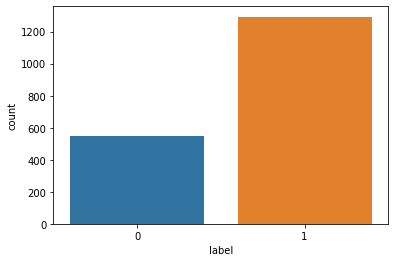

In [85]:
columns = ['label', 'text', 'afinn_positive', 'afinn_negative', 'nrc_positive', 'nrc_negative', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust', 'mpqa_positive', 'mpqa_negative', 'mpqa_strong_subjectivty']
df_reddit=encode_data(df_reddit, columns, encodedict={'positive': 1, 'negative': 0})
plot(df_reddit, "Reddit") 


In [86]:
df_reddit.head(2)

,label,text,afinn_positive,afinn_negative,nrc_positive,nrc_negative,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_sadness,nrc_surprise,nrc_trust,mpqa_positive,mpqa_negative,mpqa_strong_subjectivty
0,0,My male cousin stopped talking to me all of su...,10.0,18.0,13.0,9.0,2.0,8.0,3.0,5.0,8.0,7.0,4.0,7.0,11.0,9.0,13.0
1,0,Drifting away from my best friend\nMy best fri...,28.0,11.0,17.0,7.0,3.0,9.0,3.0,3.0,10.0,3.0,3.0,12.0,21.0,11.0,24.0


In [87]:
X = df_reddit.iloc[:, 2:]
y = df_reddit.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [88]:
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
print("Accuracy with training data:", Logistic.score(X_train, y_train))
prob_predicted_train = Logistic.predict_proba(X_train)
print("Logloss with training data:", loss_logloss(prob_predicted_train, y_train, weighted=True))


Accuracy with training data: 0.7639902676399026
Logloss with training data: 0.6699137756628144


In [89]:
y_pred = Logistic.predict(X_test)
print("Accuracy with test data:", Logistic.score(X_test, y_test))

y_pred_proba = Logistic.predict_proba(X_test)
print("Logloss with test data:", loss_logloss(y_pred_proba, y_test, weighted=True))


Accuracy with test data: 0.7483552631578947
Logloss with test data: 0.6374538593709682


In [90]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.7623918174665617
Logistic accuracy on training data:  0.7639902676399026
Logistic accuracy on testing data:  0.7483552631578947


In [91]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.30      0.44       194
           1       0.75      0.96      0.84       414

    accuracy                           0.75       608
   macro avg       0.76      0.63      0.64       608
weighted avg       0.75      0.75      0.71       608



## 1.b Lexicon in use is Sentic.

In [92]:
!pip install senticnet


In [93]:
from senticnet.senticnet import SenticNet
import nltk
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [94]:
reddit.head(2)

,label,text
0,negative,My male cousin stopped talking to me all of su...
1,negative,Drifting away from my best friend\nMy best fri...


In [95]:
reddit_scentic=get_scentic_features(reddit)
encodedict={'positive': 1, 'negative': 0}
reddit_scentic['label'] = reddit_scentic['label'].map(encodedict) 
reddit_scentic.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to b

,label,text,polarity_value,polarity_label,sensitivity,introspection,temper,attitude
0,0,My male cousin stopped talking to me all of su...,13,33,13,12,-3,4
1,0,Drifting away from my best friend\nMy best fri...,6,28,10,6,-2,1


In [96]:
X = reddit_scentic.iloc[:, 2:]
y = reddit_scentic.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [97]:
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
print("Accuracy with training data:", Logistic.score(X_train, y_train))
prob_predicted_train = Logistic.predict_proba(X_train)
print("Logloss with training data:", loss_logloss(prob_predicted_train, y_train, weighted=True))


Accuracy with training data: 0.7696674776966748
Logloss with training data: 0.6727347780987293


In [98]:
y_pred = Logistic.predict(X_test)
print("Accuracy with test data:", Logistic.score(X_test, y_test))

y_pred_proba = Logistic.predict_proba(X_test)
print("Logloss with test data:", loss_logloss(y_pred_proba, y_test, weighted=True))


Accuracy with test data: 0.7483552631578947
Logloss with test data: 0.6612992608096722


In [99]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.7656176239181747
Logistic accuracy on training data:  0.7696674776966748
Logistic accuracy on testing data:  0.7483552631578947


In [100]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.32      0.45       194
           1       0.75      0.95      0.84       414

    accuracy                           0.75       608
   macro avg       0.75      0.64      0.64       608
weighted avg       0.75      0.75      0.71       608



##1.c Lexicon in use is affine_ncr



In [101]:
reddit_all_two_lexicos= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Reddit_afinn_nrc.csv'))
reddit_all_two_lexicos.head(2)

,0,1,2,3
0,10.0,18.0,13.0,9.0
1,28.0,11.0,17.0,7.0


In [102]:
df_reddit = pd.concat([reddit,reddit_all_two_lexicos], axis=1)
df_reddit.head(2)


,label,text,polarity_value,polarity_label,sensitivity,introspection,temper,attitude,0,1,2,3
0,0,My male cousin stopped talking to me all of su...,13,33,13,12,-3,4,10.0,18.0,13.0,9.0
1,0,Drifting away from my best friend\nMy best fri...,6,28,10,6,-2,1,28.0,11.0,17.0,7.0


In [103]:
X = df_reddit.iloc[:, 8:]
y = df_reddit.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [104]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.7250393391030684
Logistic accuracy on training data:  0.7274939172749392
Logistic accuracy on testing data:  0.7039473684210527


In [105]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.32      0.45       194
           1       0.75      0.95      0.84       414

    accuracy                           0.75       608
   macro avg       0.75      0.64      0.64       608
weighted avg       0.75      0.75      0.71       608



##1.d Lexicon in use is mpqa_nrc_sa


In [106]:
reddit_mpqa_nrc= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Reddit_mpqr_nrc_sa.csv'))
reddit_mpqa_nrc.head(2)

,0,1,2,3,4,5,6,7,8,9,10
0,11.0,9.0,13.0,2.0,8.0,3.0,5.0,8.0,7.0,4.0,7.0
1,21.0,11.0,24.0,3.0,9.0,3.0,3.0,10.0,3.0,3.0,12.0


In [107]:
df_reddit = pd.concat([reddit,reddit_mpqa_nrc], axis=1)
df_reddit.head(2)


,label,text,polarity_value,polarity_label,sensitivity,introspection,temper,attitude,0,1,2,3,4,5,6,7,8,9,10
0,0,My male cousin stopped talking to me all of su...,13,33,13,12,-3,4,11.0,9.0,13.0,2.0,8.0,3.0,5.0,8.0,7.0,4.0,7.0
1,0,Drifting away from my best friend\nMy best fri...,6,28,10,6,-2,1,21.0,11.0,24.0,3.0,9.0,3.0,3.0,10.0,3.0,3.0,12.0


In [108]:
X = df_reddit.iloc[:, 8:]
y = df_reddit.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [109]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.7534618410700236
Logistic accuracy on training data:  0.7599351175993512
Logistic accuracy on testing data:  0.7467105263157895


In [110]:
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.74      0.32      0.45       194
           1       0.75      0.95      0.84       414

    accuracy                           0.75       608
   macro avg       0.75      0.64      0.64       608
weighted avg       0.75      0.75      0.71       608



##1.e Lexicon in use is ncr


In [112]:
reddit_nrc= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Reddit_nrc.csv'))
reddit_nrc.head(2)

,0,1
0,13.0,9.0
1,17.0,7.0


In [113]:
df_reddit = pd.concat([reddit,reddit_nrc], axis=1)
df_reddit.head(2)

,label,text,polarity_value,polarity_label,sensitivity,introspection,temper,attitude,0,1
0,0,My male cousin stopped talking to me all of su...,13,33,13,12,-3,4,13.0,9.0
1,0,Drifting away from my best friend\nMy best fri...,6,28,10,6,-2,1,17.0,7.0


In [114]:
X = df_reddit.iloc[:, 8:]
y = df_reddit.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [115]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.7169354838709677
Logistic accuracy on training data:  0.7210056772100568
Logistic accuracy on testing data:  0.694078947368421


In [116]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.32      0.45       194
           1       0.75      0.95      0.84       414

    accuracy                           0.75       608
   macro avg       0.75      0.64      0.64       608
weighted avg       0.75      0.75      0.71       608



##1.f Lexicon in use is mpqa


In [117]:
reddit_mpqa= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Reddit_mpqa.csv'))
reddit_mpqa.head(2)

,0,1,2
0,11.0,9.0,13.0
1,21.0,11.0,24.0


In [118]:
df_reddit = pd.concat([reddit,reddit_mpqa], axis=1)
df_reddit.head(2)

,label,text,polarity_value,polarity_label,sensitivity,introspection,temper,attitude,0,1,2
0,0,My male cousin stopped talking to me all of su...,13,33,13,12,-3,4,11.0,9.0,13.0
1,0,Drifting away from my best friend\nMy best fri...,6,28,10,6,-2,1,21.0,11.0,24.0


In [119]:
X = df_reddit.iloc[:, 8:]
y = df_reddit.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [120]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.7080710726462104
Logistic accuracy on training data:  0.7120843471208435
Logistic accuracy on testing data:  0.6776315789473685


In [121]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.32      0.45       194
           1       0.75      0.95      0.84       414

    accuracy                           0.75       608
   macro avg       0.75      0.64      0.64       608
weighted avg       0.75      0.75      0.71       608



##1.g Lexicon in use is affine


In [122]:
reddit_affin= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Reddit_afinn.csv'))
reddit_affin.head(2)

,0,1
0,10.0,18.0
1,28.0,11.0


In [123]:
df_reddit = pd.concat([reddit,reddit_affin], axis=1)
df_reddit.head(2)

,label,text,polarity_value,polarity_label,sensitivity,introspection,temper,attitude,0,1
0,0,My male cousin stopped talking to me all of su...,13,33,13,12,-3,4,10.0,18.0
1,0,Drifting away from my best friend\nMy best fri...,6,28,10,6,-2,1,28.0,11.0


In [124]:
X = df_reddit.iloc[:, 8:]
y = df_reddit.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [125]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.7096380802517703
Logistic accuracy on training data:  0.7120843471208435
Logistic accuracy on testing data:  0.6726973684210527


In [126]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.32      0.45       194
           1       0.75      0.95      0.84       414

    accuracy                           0.75       608
   macro avg       0.75      0.64      0.64       608
weighted avg       0.75      0.75      0.71       608



##1.h Lexicon in use is ncr_sa


In [127]:
reddit_nrc_sa= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Reddit_nrc_sa.csv'))
reddit_nrc_sa.head(2)

,0,1,2,3,4,5,6,7
0,2.0,8.0,3.0,5.0,8.0,7.0,4.0,7.0
1,3.0,9.0,3.0,3.0,10.0,3.0,3.0,12.0


In [128]:
df_reddit = pd.concat([reddit,reddit_nrc_sa], axis=1)
df_reddit.head(2)

,label,text,polarity_value,polarity_label,sensitivity,introspection,temper,attitude,0,1,2,3,4,5,6,7
0,0,My male cousin stopped talking to me all of su...,13,33,13,12,-3,4,2.0,8.0,3.0,5.0,8.0,7.0,4.0,7.0
1,0,Drifting away from my best friend\nMy best fri...,6,28,10,6,-2,1,3.0,9.0,3.0,3.0,10.0,3.0,3.0,12.0


In [129]:
X = df_reddit.iloc[:, 8:]
y = df_reddit.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [130]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.7566810910044584
Logistic accuracy on training data:  0.7599351175993512
Logistic accuracy on testing data:  0.7417763157894737


In [131]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.32      0.45       194
           1       0.75      0.95      0.84       414

    accuracy                           0.75       608
   macro avg       0.75      0.64      0.64       608
weighted avg       0.75      0.75      0.71       608



# 2. Part Second: Mixed Dataset

In [135]:
Mixed= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed.csv'))

In [136]:
Mixed.head(2)

,label,text
0,negative,My male cousin stopped talking to me all of su...
1,negative,Drifting away from my best friend\nMy best fri...


In [137]:
mixed_all_four_lexicons= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed_afinn_nrc_nrc_sa_mpqa.csv'))

In [138]:
df_mixed = pd.concat([Mixed,mixed_all_four_lexicons], axis=1)
df_mixed.head(2)

,label,text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,negative,My male cousin stopped talking to me all of su...,10.0,18.0,13.0,9.0,2.0,8.0,3.0,5.0,8.0,7.0,4.0,7.0,11.0,9.0,13.0
1,negative,Drifting away from my best friend\nMy best fri...,28.0,11.0,17.0,7.0,3.0,9.0,3.0,3.0,10.0,3.0,3.0,12.0,21.0,11.0,24.0


In [139]:
df_mixed.shape[0]

2810

##2.a Lexicon in use is afinn_nrc_nrc_sa_mpqa.

Dataset: Mixed 



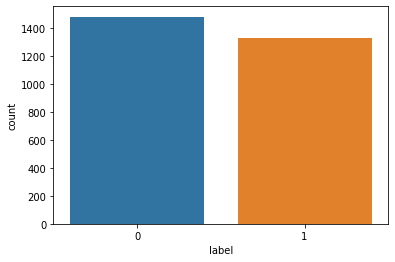

In [140]:
columns = ['label', 'text', 'afinn_positive', 'afinn_negative', 'nrc_positive', 'nrc_negative', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust', 'mpqa_positive', 'mpqa_negative', 'mpqa_strong_subjectivty']
df_mixed=encode_data(df_mixed, columns, encodedict={'positive': 1, 'negative': 0})
plot(df_mixed, "Mixed") 


In [141]:
X = df_mixed.iloc[:, 2:]
y = df_mixed.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [142]:
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
print("Accuracy with training data:", Logistic.score(X_train, y_train))
prob_predicted_train = Logistic.predict_proba(X_train)
print("Logloss with training data:", loss_logloss(prob_predicted_train, y_train, weighted=False))

Accuracy with training data: 0.6992561105207227
Logloss with training data: 0.6006821871982312


In [143]:
y_pred = Logistic.predict(X_test)
print("Accuracy with test data:", Logistic.score(X_test, y_test))

y_pred_proba = Logistic.predict_proba(X_test)
print("Logloss with test data:", loss_logloss(y_pred_proba, y_test, weighted=False))


Accuracy with test data: 0.7122844827586207
Logloss with test data: 0.5910839793065426


In [144]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.6896994258696386
Logistic accuracy on training data:  0.6992561105207227
Logistic accuracy on testing data:  0.7122844827586207


In [145]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.83      0.75       474
           1       0.77      0.59      0.67       454

    accuracy                           0.71       928
   macro avg       0.72      0.71      0.71       928
weighted avg       0.72      0.71      0.71       928



## 2.b Lexicon in use is Sentic.

In [146]:
Mixed.head(2)

,label,text
0,negative,My male cousin stopped talking to me all of su...
1,negative,Drifting away from my best friend\nMy best fri...


In [147]:
mixed_scentic=get_scentic_features(Mixed)
encodedict={'positive': 1, 'negative': 0}
mixed_scentic['label'] = mixed_scentic['label'].map(encodedict) 
mixed_scentic.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to b

,label,text,polarity_value,polarity_label,sensitivity,introspection,temper,attitude
0,0,My male cousin stopped talking to me all of su...,13,33,13,12,-3,4
1,0,Drifting away from my best friend\nMy best fri...,6,28,10,6,-2,1


In [148]:
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
print("Accuracy with training data:", Logistic.score(X_train, y_train))
prob_predicted_train = Logistic.predict_proba(X_train)
print("Logloss with training data:", loss_logloss(prob_predicted_train, y_train, weighted=True))


Accuracy with training data: 0.6992561105207227
Logloss with training data: 0.6048889726410016


In [149]:
y_pred = Logistic.predict(X_test)
print("Accuracy with test data:", Logistic.score(X_test, y_test))

y_pred_proba = Logistic.predict_proba(X_test)
print("Logloss with test data:", loss_logloss(y_pred_proba, y_test, weighted=True))


Accuracy with test data: 0.7122844827586207
Logloss with test data: 0.5922016734946323


In [150]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.6896994258696386
Logistic accuracy on training data:  0.6992561105207227
Logistic accuracy on testing data:  0.7122844827586207


In [151]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.83      0.75       474
           1       0.77      0.59      0.67       454

    accuracy                           0.71       928
   macro avg       0.72      0.71      0.71       928
weighted avg       0.72      0.71      0.71       928



##2.c Lexicon in use is affine_ncr

In [152]:
Mixed_all_two_lexicos= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed_afinn_nrc.csv'))
Mixed_all_two_lexicos.head(3)

,0,1,2,3
0,10.0,18.0,13.0,9.0
1,28.0,11.0,17.0,7.0
2,29.0,11.0,14.0,4.0


In [153]:
Mixed= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed.csv'))
Mixed.head(2)

,label,text
0,negative,My male cousin stopped talking to me all of su...
1,negative,Drifting away from my best friend\nMy best fri...


In [154]:
df_mixed = pd.concat([Mixed,Mixed_all_two_lexicos], axis=1)
df_mixed.head(2)

,label,text,0,1,2,3
0,negative,My male cousin stopped talking to me all of su...,10.0,18.0,13.0,9.0
1,negative,Drifting away from my best friend\nMy best fri...,28.0,11.0,17.0,7.0


In [155]:
columns = ['label', 'text', 'afinn_positive', 'afinn_negative', 'nrc_positive', 'nrc_negative']
df_mixed=encode_data(df_mixed, columns, encodedict={'positive': 1, 'negative': 0})


In [156]:
X = df_mixed.iloc[:, 2:]
y = df_mixed.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [157]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.6471884498480243
Logistic accuracy on training data:  0.6466524973432518
Logistic accuracy on testing data:  0.6476293103448276


In [158]:
y_pred = Logistic.predict(X_test)
print("Accuracy with test data:", Logistic.score(X_test, y_test))

y_pred_proba = Logistic.predict_proba(X_test)
print("Logloss with test data:", loss_logloss(y_pred_proba, y_test, weighted=True))


Accuracy with test data: 0.6476293103448276
Logloss with test data: 0.6520430076912936


In [159]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.79      0.70       474
           1       0.69      0.50      0.58       454

    accuracy                           0.65       928
   macro avg       0.66      0.64      0.64       928
weighted avg       0.66      0.65      0.64       928



##2.d Lexicon in use is mpqr_ncr_sa

In [163]:
Mixed_mpqr_nrc_sa= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed_mpqr_nrc_sa.csv'))
Mixed_mpqr_nrc_sa.head(3)

,0,1,2,3,4,5,6,7,8,9,10
0,11.0,9.0,13.0,2.0,8.0,3.0,5.0,8.0,7.0,4.0,7.0
1,21.0,11.0,24.0,3.0,9.0,3.0,3.0,10.0,3.0,3.0,12.0
2,13.0,6.0,20.0,0.0,3.0,0.0,1.0,12.0,0.0,0.0,1.0


In [164]:
Mixed= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed.csv'))
Mixed.head(2)

,label,text
0,negative,My male cousin stopped talking to me all of su...
1,negative,Drifting away from my best friend\nMy best fri...


In [165]:
df_mixed = pd.concat([Mixed,Mixed_mpqr_nrc_sa], axis=1)
df_mixed.head(2)

,label,text,0,1,2,3,4,5,6,7,8,9,10
0,negative,My male cousin stopped talking to me all of su...,11.0,9.0,13.0,2.0,8.0,3.0,5.0,8.0,7.0,4.0,7.0
1,negative,Drifting away from my best friend\nMy best fri...,21.0,11.0,24.0,3.0,9.0,3.0,3.0,10.0,3.0,3.0,12.0


In [166]:
columns = ['label', 'text', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust', 'mpqa_positive', 'mpqa_negative', 'mpqa_strong_subjectivty']
df_mixed=encode_data(df_mixed, columns, encodedict={'positive': 1, 'negative': 0})


In [167]:
X = df_mixed.iloc[:, 2:]
y = df_mixed.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [168]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.6859900934369019
Logistic accuracy on training data:  0.6928799149840595
Logistic accuracy on testing data:  0.7122844827586207


In [169]:
y_pred = Logistic.predict(X_test)
print("Accuracy with test data:", Logistic.score(X_test, y_test))

y_pred_proba = Logistic.predict_proba(X_test)
print("Logloss with test data:", loss_logloss(y_pred_proba, y_test, weighted=True))


Accuracy with test data: 0.7122844827586207
Logloss with test data: 0.5964029364129982


In [170]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.83      0.75       474
           1       0.77      0.59      0.67       454

    accuracy                           0.71       928
   macro avg       0.72      0.71      0.71       928
weighted avg       0.72      0.71      0.71       928



##2.e Lexicon in use is affin

In [171]:
Mixed_afinn= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed_afinn.csv'))
Mixed_afinn.head(3)

,0,1
0,10.0,18.0
1,28.0,11.0
2,29.0,11.0


In [172]:
Mixed= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed.csv'))
Mixed.head(2)

,label,text
0,negative,My male cousin stopped talking to me all of su...
1,negative,Drifting away from my best friend\nMy best fri...


In [173]:
df_mixed = pd.concat([Mixed,Mixed_afinn], axis=1)
df_mixed.head(2)

,label,text,0,1
0,negative,My male cousin stopped talking to me all of su...,10.0,18.0
1,negative,Drifting away from my best friend\nMy best fri...,28.0,11.0


In [174]:
columns = ['label', 'text', 'afinn_positive', 'afinn_negative']
df_mixed=encode_data(df_mixed, columns, encodedict={'positive': 1, 'negative': 0})


In [175]:
X = df_mixed.iloc[:, 2:]
y = df_mixed.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [176]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.621164021164021
Logistic accuracy on training data:  0.6222104144527099
Logistic accuracy on testing data:  0.6023706896551724


In [177]:
y_pred = Logistic.predict(X_test)
print("Accuracy with test data:", Logistic.score(X_test, y_test))

y_pred_proba = Logistic.predict_proba(X_test)
print("Logloss with test data:", loss_logloss(y_pred_proba, y_test, weighted=True))


Accuracy with test data: 0.6023706896551724
Logloss with test data: 0.6710161332951713


In [178]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.80      0.67       474
           1       0.65      0.40      0.50       454

    accuracy                           0.60       928
   macro avg       0.62      0.60      0.58       928
weighted avg       0.62      0.60      0.59       928



##2.f Lexicon in use is ncr

In [179]:
Mixed_nrc= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed_nrc.csv'))
Mixed_nrc.head(3)

,0,1
0,13.0,9.0
1,17.0,7.0
2,14.0,4.0


In [180]:
Mixed= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed.csv'))
Mixed.head(2)

,label,text
0,negative,My male cousin stopped talking to me all of su...
1,negative,Drifting away from my best friend\nMy best fri...


In [181]:
df_mixed = pd.concat([Mixed,Mixed_nrc], axis=1)
df_mixed.head(2)

,label,text,0,1
0,negative,My male cousin stopped talking to me all of su...,13.0,9.0
1,negative,Drifting away from my best friend\nMy best fri...,17.0,7.0


In [182]:
columns = ['label', 'text', 'nrc_positive', 'nrc_negative']
df_mixed=encode_data(df_mixed, columns, encodedict={'positive': 1, 'negative': 0})


In [183]:
X = df_mixed.iloc[:, 2:]
y = df_mixed.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [184]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.6301756163458292
Logistic accuracy on training data:  0.6312433581296493
Logistic accuracy on testing data:  0.6368534482758621


In [185]:
y_pred = Logistic.predict(X_test)
print("Accuracy with test data:", Logistic.score(X_test, y_test))

y_pred_proba = Logistic.predict_proba(X_test)
print("Logloss with test data:", loss_logloss(y_pred_proba, y_test, weighted=True))


Accuracy with test data: 0.6368534482758621
Logloss with test data: 0.6544889690657343


In [186]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.79      0.69       474
           1       0.68      0.48      0.56       454

    accuracy                           0.64       928
   macro avg       0.65      0.63      0.63       928
weighted avg       0.65      0.64      0.63       928



##2.g Lexicon in use is mpqr

In [187]:
Mixed_mpqa= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed_mpqa.csv'))
Mixed_mpqa.head(3)

,0,1,2
0,11.0,9.0,13.0
1,21.0,11.0,24.0
2,13.0,6.0,20.0


In [188]:
Mixed= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed.csv'))
Mixed.head(2)

,label,text
0,negative,My male cousin stopped talking to me all of su...
1,negative,Drifting away from my best friend\nMy best fri...


In [189]:
df_mixed = pd.concat([Mixed,Mixed_mpqa], axis=1)
df_mixed.head(2)

,label,text,0,1,2
0,negative,My male cousin stopped talking to me all of su...,11.0,9.0,13.0
1,negative,Drifting away from my best friend\nMy best fri...,21.0,11.0,24.0


In [190]:
columns = ['label', 'text', 'mpqa_positive', 'mpqa_negative', 'mpqa_strong_subjectivty']
df_mixed=encode_data(df_mixed, columns, encodedict={'positive': 1, 'negative': 0})


In [191]:
X = df_mixed.iloc[:, 2:]
y = df_mixed.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [192]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.6020347855454238
Logistic accuracy on training data:  0.6046758767268863
Logistic accuracy on testing data:  0.6045258620689655


In [193]:
y_pred = Logistic.predict(X_test)
print("Accuracy with test data:", Logistic.score(X_test, y_test))

y_pred_proba = Logistic.predict_proba(X_test)
print("Logloss with test data:", loss_logloss(y_pred_proba, y_test, weighted=True))


Accuracy with test data: 0.6045258620689655
Logloss with test data: 0.6702624797540327


In [194]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.80      0.67       474
           1       0.66      0.40      0.50       454

    accuracy                           0.60       928
   macro avg       0.62      0.60      0.59       928
weighted avg       0.62      0.60      0.59       928



##2.h Lexicon in use is ncr_sa

In [195]:
Mixed_nrc_sa= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed_nrc_sa.csv'))
Mixed_nrc_sa.head(3)

,0,1,2,3,4,5,6,7
0,2.0,8.0,3.0,5.0,8.0,7.0,4.0,7.0
1,3.0,9.0,3.0,3.0,10.0,3.0,3.0,12.0
2,0.0,3.0,0.0,1.0,12.0,0.0,0.0,1.0


In [196]:
Mixed= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/Mixed.csv'))
Mixed.head(2)

,label,text
0,negative,My male cousin stopped talking to me all of su...
1,negative,Drifting away from my best friend\nMy best fri...


In [198]:
df_mixed = pd.concat([Mixed,Mixed_nrc_sa], axis=1)
df_mixed.head(2)

,label,text,0,1,2,3,4,5,6,7
0,negative,My male cousin stopped talking to me all of su...,2.0,8.0,3.0,5.0,8.0,7.0,4.0,7.0
1,negative,Drifting away from my best friend\nMy best fri...,3.0,9.0,3.0,3.0,10.0,3.0,3.0,12.0


In [199]:
columns = ['label', 'text', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust']
df_mixed=encode_data(df_mixed, columns, encodedict={'positive': 1, 'negative': 0})


In [200]:
X = df_mixed.iloc[:, 2:]
y = df_mixed.iloc[:, 0]
X_train, X_test, y_train, y_test = split(X, y)
X_train, X_test = normalize(StandardScaler(), X_train, X_test)
#print(y_test[:10])

In [201]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.6891872115276371
Logistic accuracy on training data:  0.6923485653560042
Logistic accuracy on testing data:  0.7101293103448276


In [202]:
y_pred = Logistic.predict(X_test)
print("Accuracy with test data:", Logistic.score(X_test, y_test))

y_pred_proba = Logistic.predict_proba(X_test)
print("Logloss with test data:", loss_logloss(y_pred_proba, y_test, weighted=True))


Accuracy with test data: 0.7101293103448276
Logloss with test data: 0.596962109581146


In [203]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.82      0.74       474
           1       0.76      0.59      0.67       454

    accuracy                           0.71       928
   macro avg       0.72      0.71      0.71       928
weighted avg       0.72      0.71      0.71       928



# 3. Part Third: CLPsych Dataset

##3.a Lexicon in use is afinn_nrc_nrc_sa_mpqa_train

In [207]:
df_clpsych_train= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/CLPsych_train_binary.csv'))

In [208]:
df_clpsych_test= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/CLPsych_test_binary.csv'))

In [209]:
#train
clpsych_all_four_lexicons_train= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/clpsych_afinn_nrc_nrc_sa_mpqa_train.csv'))

In [210]:
#test
clpsych_all_four_lexicons_test= pd.read_csv(Path('/content/drive/My Drive/DSP/data/bachelor/clpsych_afinn_nrc_nrc_sa_mpqa_test.csv'))

In [211]:
train_clpsych= pd.concat([df_clpsych_train, clpsych_all_four_lexicons_train], axis=1)
train_clpsych.head(2)

,label,text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,depression_ctrl,Game over RT : Life is so unpredictable. Be gr...,3156.0,2594.0,1670.0,1048.0,517.0,872.0,454.0,589.0,880.0,524.0,353.0,1170.0,2011.0,1148.0,1860.0
1,depression,Happy ! Guys: please check your balls monthly ...,5843.0,4220.0,3241.0,2227.0,1271.0,1401.0,797.0,1536.0,1666.0,1361.0,657.0,1862.0,3691.0,2452.0,4015.0


In [212]:
test_clpsych= pd.concat([df_clpsych_test, clpsych_all_four_lexicons_test], axis=1)
#test_clpsych.head(2)

In [213]:
train_clpsych.shape[0]

654

In [214]:
test_clpsych.shape[0]

300

Train set
Dataset: CLPsych 



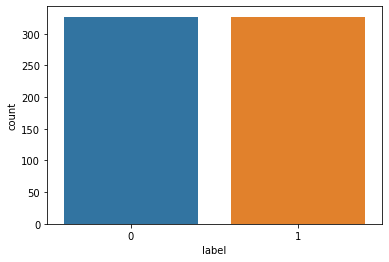

In [215]:
columns = ['label', 'text', 'afinn_positive', 'afinn_negative', 'nrc_positive', 'nrc_negative', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust', 'mpqa_positive', 'mpqa_negative', 'mpqa_strong_subjectivty']
train_clpsych=encode_data(train_clpsych, columns, encodedict={'depression': 1, 'depression_ctrl': 0})
print("Train set")
plot(train_clpsych, "CLPsych") 


In [217]:
train_clpsych.head(2)

,label,text,afinn_positive,afinn_negative,nrc_positive,nrc_negative,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_sadness,nrc_surprise,nrc_trust,mpqa_positive,mpqa_negative,mpqa_strong_subjectivty
0,0,Game over RT : Life is so unpredictable. Be gr...,3156.0,2594.0,1670.0,1048.0,517.0,872.0,454.0,589.0,880.0,524.0,353.0,1170.0,2011.0,1148.0,1860.0
1,1,Happy ! Guys: please check your balls monthly ...,5843.0,4220.0,3241.0,2227.0,1271.0,1401.0,797.0,1536.0,1666.0,1361.0,657.0,1862.0,3691.0,2452.0,4015.0


Test set
Dataset: CLPsych 



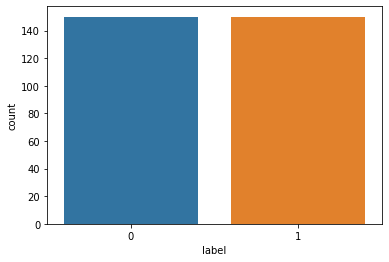

In [218]:
columns = ['label', 'text', 'afinn_positive', 'afinn_negative', 'nrc_positive', 'nrc_negative', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust', 'mpqa_positive', 'mpqa_negative', 'mpqa_strong_subjectivty']
test_clpsych=encode_data(test_clpsych, columns, encodedict={'depression': 1, 'depression_ctrl': 0})
print("Test set")
plot(test_clpsych, "CLPsych") 


In [219]:
X_train = train_clpsych.iloc[:, 2:]
y_train = train_clpsych.iloc[:, 0]

X_test = test_clpsych.iloc[:, 2:]
y_test = test_clpsych.iloc[:, 0]

In [220]:
X_train, X_test = normalize(StandardScaler(), X_train, X_test)

In [221]:
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
print("Accuracy with training data:", Logistic.score(X_train, y_train))
prob_predicted_train = Logistic.predict_proba(X_train)
print("Logloss with training data:", loss_logloss(prob_predicted_train, y_train, weighted=True))


Accuracy with training data: 0.6406727828746177
Logloss with training data: 0.6312328471826768


In [222]:
y_pred = Logistic.predict(X_test)
print("Accuracy with test data:", Logistic.score(X_test, y_test))

y_pred_proba = Logistic.predict_proba(X_test)
print("Logloss with test data:", loss_logloss(y_pred_proba, y_test, weighted=True))


Accuracy with test data: 0.6433333333333333
Logloss with test data: 0.6380047931711335


In [223]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.6084848484848484
Logistic accuracy on training data:  0.6406727828746177
Logistic accuracy on testing data:  0.6433333333333333


In [224]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.67      0.65       150
           1       0.65      0.62      0.63       150

    accuracy                           0.64       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.64      0.64      0.64       300



##3.b Lexicon in use is Sentic

In [ ]:
df_clpsych_train_scentic=get_scentic_features(df_clpsych_train)
encodedict={'depression': 1, 'depression_ctrl': 0}
df_clpsych_train_scentic['label'] = df_clpsych_train_scentic['label'].map(encodedict) 
df_clpsych_train_scentic.head(2)

,label,text,polarity_value,polarity_label,sensitivity,introspection,temper,attitude
0,0,Game over RT : Life is so unpredictable. Be gr...,1280,3481,831,1040,38,209
1,1,Happy ! Guys: please check your balls monthly ...,2149,6548,1431,1670,44,639


In [ ]:
df_clpsych_test_scentic=get_scentic_features(df_clpsych_test)
df_clpsych_test_scentic['label'] = df_clpsych_test_scentic['label'].map(encodedict) 
df_clpsych_test_scentic.head(2)

,label,text,polarity_value,polarity_label,sensitivity,introspection,temper,attitude
0,1,: Going with . Look for my lipstick in early t...,2304,4832,1916,2141,4,287
1,0,: Paolo Nutini - No Other Way RT : my dreams h...,1277,3364,850,1190,14,145


In [ ]:
X_train = df_clpsych_train_scentic.iloc[:, 2:]
y_train = df_clpsych_train_scentic.iloc[:, 0]

X_test = df_clpsych_test_scentic.iloc[:, 2:]
y_test = df_clpsych_test_scentic.iloc[:, 0]

In [ ]:
X_train, X_test = normalize(StandardScaler(), X_train, X_test)

In [ ]:
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
print("Accuracy with training data:", Logistic.score(X_train, y_train))
prob_predicted_train = Logistic.predict_proba(X_train)
print("Logloss with training data:", loss_logloss(prob_predicted_train, y_train, weighted=True))


Accuracy with training data: 0.6162079510703364
Logloss with training data: 0.655426506797095


In [ ]:
y_pred = Logistic.predict(X_test)
print("Accuracy with test data:", Logistic.score(X_test, y_test))

y_pred_proba = Logistic.predict_proba(X_test)
print("Logloss with test data:", loss_logloss(y_pred_proba, y_test, weighted=True))


Accuracy with test data: 0.6433333333333333
Logloss with test data: 0.6569092869990207


In [ ]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.6022843822843822
Logistic accuracy on training data:  0.6162079510703364
Logistic accuracy on testing data:  0.6433333333333333


In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63       150
           1       0.64      0.67      0.65       150

    accuracy                           0.64       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.64      0.64      0.64       300



##3.c Lexicon in use is afinn_nrc


In [227]:
X_train = train_clpsych.iloc[:, 2:6]
y_train = train_clpsych.iloc[:, 0]

X_test = test_clpsych.iloc[:, 2:6]
y_test = test_clpsych.iloc[:, 0]

In [228]:
X_train.head(2)

,afinn_positive,afinn_negative,nrc_positive,nrc_negative
0,3156.0,2594.0,1670.0,1048.0
1,5843.0,4220.0,3241.0,2227.0


In [ ]:
X_train, X_test = normalize(StandardScaler(), X_train, X_test)

In [ ]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.512051282051282
Logistic accuracy on training data:  0.5259938837920489
Logistic accuracy on testing data:  0.5566666666666666


In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63       150
           1       0.64      0.67      0.65       150

    accuracy                           0.64       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.64      0.64      0.64       300



##3.d Lexicon in use is mpqa_nrs_sa


In [229]:
X_train = train_clpsych.iloc[:, 6:]
y_train = train_clpsych.iloc[:, 0]

X_test = test_clpsych.iloc[:, 6:]
y_test = test_clpsych.iloc[:, 0]

In [230]:
X_train.head(2)

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_sadness,nrc_surprise,nrc_trust,mpqa_positive,mpqa_negative,mpqa_strong_subjectivty
0,517.0,872.0,454.0,589.0,880.0,524.0,353.0,1170.0,2011.0,1148.0,1860.0
1,1271.0,1401.0,797.0,1536.0,1666.0,1361.0,657.0,1862.0,3691.0,2452.0,4015.0


In [231]:
X_train, X_test = normalize(StandardScaler(), X_train, X_test)

In [232]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.5825874125874126
Logistic accuracy on training data:  0.6085626911314985
Logistic accuracy on testing data:  0.63


In [233]:
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.64      0.67      0.65       150
           1       0.65      0.62      0.63       150

    accuracy                           0.64       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.64      0.64      0.64       300



##3.e Lexicon in use is nrc


In [236]:
X_train = train_clpsych.iloc[:, 4:6]
y_train = train_clpsych.iloc[:, 0]

X_test = test_clpsych.iloc[:, 4:6]
y_test = test_clpsych.iloc[:, 0]

In [237]:
X_train.head(2)

,nrc_positive,nrc_negative
0,1670.0,1048.0
1,3241.0,2227.0


In [238]:
X_train, X_test = normalize(StandardScaler(), X_train, X_test)

In [239]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.5135431235431236
Logistic accuracy on training data:  0.518348623853211
Logistic accuracy on testing data:  0.5666666666666667


In [240]:
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.64      0.67      0.65       150
           1       0.65      0.62      0.63       150

    accuracy                           0.64       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.64      0.64      0.64       300



##3.f Lexicon in use is afinn


In [241]:
X_train = train_clpsych.iloc[:, 2:4]
y_train = train_clpsych.iloc[:, 0]

X_test = test_clpsych.iloc[:, 2:4]
y_test = test_clpsych.iloc[:, 0]

In [242]:
X_train.head(2)

,afinn_positive,afinn_negative
0,3156.0,2594.0
1,5843.0,4220.0


In [243]:
X_train, X_test = normalize(StandardScaler(), X_train, X_test)

In [244]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.534988344988345
Logistic accuracy on training data:  0.5290519877675841
Logistic accuracy on testing data:  0.59


In [245]:
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.64      0.67      0.65       150
           1       0.65      0.62      0.63       150

    accuracy                           0.64       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.64      0.64      0.64       300



##3.g Lexicon in use is mpqa


In [248]:
X_train = train_clpsych.iloc[:, 14:]
y_train = train_clpsych.iloc[:, 0]

X_test = test_clpsych.iloc[:, 14:]
y_test = test_clpsych.iloc[:, 0]

In [249]:
X_train.head(2)

,mpqa_positive,mpqa_negative,mpqa_strong_subjectivty
0,2011.0,1148.0,1860.0
1,3691.0,2452.0,4015.0


In [250]:
X_train, X_test = normalize(StandardScaler(), X_train, X_test)

In [251]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.5303729603729603
Logistic accuracy on training data:  0.5336391437308868
Logistic accuracy on testing data:  0.5333333333333333


In [252]:
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.64      0.67      0.65       150
           1       0.65      0.62      0.63       150

    accuracy                           0.64       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.64      0.64      0.64       300



##3.h Lexicon in use is nrc_sa


In [257]:
X_train = train_clpsych.iloc[:, 6:14]
y_train = train_clpsych.iloc[:, 0]

X_test = test_clpsych.iloc[:, 6:14]
y_test = test_clpsych.iloc[:, 0]

In [258]:
X_train.head(2)

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_sadness,nrc_surprise,nrc_trust
0,517.0,872.0,454.0,589.0,880.0,524.0,353.0,1170.0
1,1271.0,1401.0,797.0,1536.0,1666.0,1361.0,657.0,1862.0


In [259]:
X_train, X_test = normalize(StandardScaler(), X_train, X_test)

In [260]:
#Cross validation
Logistic = LogisticRegression(random_state=0, solver='lbfgs')
Logistic.fit(X_train, y_train)
scores = cross_val_score(
    Logistic, 
    X_train, 
    y_train, 
    cv=10)
print("Cross validated accuracy: ", 
      np.average(scores))
print("Logistic accuracy on training data: ", 
      Logistic.score(X_train, y_train))
print("Logistic accuracy on testing data: ", 
      Logistic.score(X_test, y_test))


Cross validated accuracy:  0.5824475524475525
Logistic accuracy on training data:  0.5963302752293578
Logistic accuracy on testing data:  0.5966666666666667


In [261]:
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.64      0.67      0.65       150
           1       0.65      0.62      0.63       150

    accuracy                           0.64       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.64      0.64      0.64       300



In [ ]:
"""lda = LinearDiscriminantAnalysis()

    lda.fit(X_train, y_train)

    print("Accuracy with training data:", lda.score(X_train, y_train))

    prob_predicted_train = lda.predict_proba(X_train)
    print("Logloss with training data:", loss_logloss(prob_predicted_train, y_train))

    y_predicted = lda.predict(X_test)
    prob_predicted = lda.predict_proba(X_test)

    write_submission_file_accuracy(y_predicted, filename=filename_prefix+"_accuracy.csv")
    write_submission_file_logloss(finalize_logloss_output(prob_predicted), filename=filename_prefix+"_logloss.csv")
    
    # cross validate
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    test_scores = []
    for i_train, i_test in skf.split(X_train, y_train):
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train[i_train], y_train[i_train])
        test_scores.append(lda.score(X_train[i_test], y_train[i_test]))

    print("Validation error:", np.average(test_scores))"""

'lda = LinearDiscriminantAnalysis()\n\n    lda.fit(X_train, y_train)\n\n    print("Accuracy with training data:", lda.score(X_train, y_train))\n\n    prob_predicted_train = lda.predict_proba(X_train)\n    print("Logloss with training data:", loss_logloss(prob_predicted_train, y_train))\n\n    y_predicted = lda.predict(X_test)\n    prob_predicted = lda.predict_proba(X_test)\n\n    write_submission_file_accuracy(y_predicted, filename=filename_prefix+"_accuracy.csv")\n    write_submission_file_logloss(finalize_logloss_output(prob_predicted), filename=filename_prefix+"_logloss.csv")\n    \n    # cross validate\n    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)\n    test_scores = []\n    for i_train, i_test in skf.split(X_train, y_train):\n        lda = LinearDiscriminantAnalysis()\n        lda.fit(X_train[i_train], y_train[i_train])\n        test_scores.append(lda.score(X_train[i_test], y_train[i_test]))\n\n    print("Validation error:", np.average(test_scores))'

In [ ]:
"""# cross validate
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
test_scores = []
for i_train, i_test in skf.split(X_train, y_train):
  
  Logistic = LogisticRegression(random_state=0, solver='lbfgs')
  Logistic.fit(X_train[i_train], y_train[i_train])

  test_scores.append(Logistic.score(X_train[i_test], y_train[i_test]))

print("Validation error:", np.average(test_scores))"""
